# Initial Setups

## Setup Environment and Project Path Configs

In [11]:
# General CPU Usage Optimization
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['OPENBLAS_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

import time

# PyTorch-specific CPU Usage Optimization
import torch
try:
    torch.set_num_threads(16)
except RuntimeError as e:
    print(f"Warning: Could not set torch.set_num_threads.\n{e}")

try:
    torch.set_num_interop_threads(16)
except RuntimeError as e:
    print(f"Warning: Could not set torch.set_num_interop_threads.\n{e}")

print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch interop threads: {torch.get_num_interop_threads()}")

# Configure Project Path for Module Imports
import sys
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()

# Navigate up to the project root directory
project_root = Path(current_dir).parent.resolve()

# Add the project root to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

# General Utility for Timestamps
from datetime import datetime

# Utility for Git commit ID for reproducibility
import subprocess

# Utility Function for Git Commit Hash
def get_git_commit_hash():
    try:
        # Get the short commit hash
        commit_hash = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip().decode('ascii')
        return commit_hash
    except (subprocess.CalledProcessError, FileNotFoundError):
        return "unknown_commit"

current_commit_hash = get_git_commit_hash()
print(f"Current Git Commit ID: {current_commit_hash}")

PyTorch threads: 16
PyTorch interop threads: 16
Project root added to sys.path: C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction
Current Git Commit ID: 271d2f4


## Import Core Libraries

In [12]:
# Data Manipulation
import pandas as pd
import numpy as np

# RDKit for Molecule Handling
from rdkit import Chem
from rdkit.Chem import AllChem

# PyTorch Core for Neural Networks
import torch.nn as nn # Neural network modules like Linear, ReLU
import torch.nn.functional as F # Functional interface for activations, e.g. F.relu

# PyTorch Geometric for Graph Neural Networks
from torch_geometric.data import Data # The graph data object in PyG
from torch_geometric.loader import DataLoader as PyGDataLoader # PyG DataLoader for graphs
import torch_geometric.nn as pyg_nn # Common GNN layers (e.g., GCNConv, GraphSAGEConv)
import torch_geometric.utils as pyg_utils # Utility functions for graph manipulation

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Import Custom Model Classes
try:
    from src.models.mlp_models import MLP
    print("MLP model class imported successfully from src.models.mlp_models.")
except ImportError as e:
    print(f"ERROR: Could not import MLP class. Please check path and file: {e}")
    print("Ensure 'src/models/mlp_models.py' exists relative to your project root and contains the 'MLP' class.")

try:
    from src.models.gnn_models import GNN
    print("GNN model class imported successfully from src.models.gnn_models.")
except ImportError as e:
    print(f"ERROR: Could not import GNN class. Please check path and file: {e}")
    print("Ensure 'src/models/gnn_models.py' exists relative to your project root and contains the 'GNN' class.")

MLP model class imported successfully from src.models.mlp_models.
GNN model class imported successfully from src.models.gnn_models.


## Import Utility Libraries

In [13]:
# Joblib for Model Loading/Saving (used for XGBoost models)
import joblib

# Hyperparameter Optimization Library (for loading studies)
import optuna

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Warnings for Cleaner Output
import warnings
warnings.filterwarnings('ignore')

## Define Device (For PyTorch/PyG Models)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Define Essential Directories

In [17]:
# Define paths for data splits, PyG Data graph objects, final models, and Optuna studies
data_splits_dir = Path("../data/splits") # Universal data splits
pyg_data_graphs_dir = Path("../data/splits/pyg_data_graphs") # Directory for saved PyG Data objects

xgboost_models_dir = Path("../models/xgb")
mlp_models_dir = Path("../models/mlp")
gnn_models_dir = Path("../models/gnn")

# Optuna database paths
optuna_studies_dir = Path("../studies")

print("\n--- Verifying Directory Existence ---")

directories_to_check = {
    "Data Splits Directory": data_splits_dir,
    "PyG Data Graphs Directory": pyg_data_graphs_dir,
    "XGBoost Models Directory": xgboost_models_dir,
    "MLP Models Directory": mlp_models_dir,
    "GNN Models Directory": gnn_models_dir,
    "Optuna Studies Database Directory": optuna_studies_dir
}

for name, path in directories_to_check.items():
    if path.is_dir():
        print(f"{name}: '{path.resolve()}' exists.")
    else:
        print(f"{name}: '{path.resolve()}' does NOT exist. Please ensure it is created and populated before running this notebook.")

print("--- Directory Verification Complete ---")

# Define full paths to your Optuna databases for loading
xgboost_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'xgboost_study/xgb_optuna_study.db'}"
mlp_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'mlp_study/mlp_optuna_study.db'}"
gnn_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'gnn_study/gnn_optuna_study.db'}"

print("\nAll paths configured and necessary directories ensured.")


--- Verifying Directory Existence ---
Data Splits Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\data\splits' exists.
PyG Data Graphs Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\data\splits\pyg_data_graphs' exists.
XGBoost Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\xgb' exists.
MLP Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\mlp' exists.
GNN Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\gnn' exists.
Optuna Studies Database Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\studies' exists.
--- Directory Verification Complete ---

All paths configured and necessary directories ensured.


## Load Best Hyperparams for Each Model

### For XGBoost

In [22]:
print("\n--- Loading Best Hyperparameters from XGBoost Optuna Study ---")
xgboost_best_params = {}
try:
    xgboost_study = optuna.load_study(
        study_name="xgboost_regression_pGI50",
        storage=xgboost_optuna_db_path
    )
    xgboost_best_params = xgboost_study.best_trial.params
    print(f"\nXGBoost best hyperparameters: {xgboost_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load XGBoost Optuna study.")


--- Loading Best Hyperparameters from XGBoost Optuna Study ---

XGBoost best hyperparameters: {'learning_rate': 0.00820193368271431, 'max_depth': 6, 'subsample': 0.9897893799354487, 'colsample_bytree': 0.7223075745984062, 'reg_alpha': 0.00012824377407451583, 'reg_lambda': 0.00397611471104642, 'gamma': 0.6775917319015243, 'n_estimators': 1148, 'min_child_weight': 9}


### For MLP

In [23]:
print("\n--- Loading Best Hyperparameters from MLP Optuna Study ---")
mlp_best_params = {}
try:
    mlp_study = optuna.load_study(
        study_name="mlp_regression_pGI50",
        storage=mlp_optuna_db_path
    )
    mlp_best_params = mlp_study.best_trial.params
    print(f"\nMLP best hyperparameters: {mlp_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load MLP Optuna study.")


--- Loading Best Hyperparameters from MLP Optuna Study ---

MLP best hyperparameters: {'hidden_size': 801, 'lr': 0.00016038661160511867, 'batch_size': 128, 'n_epochs': 195}


### For GNN

In [25]:
print("\n--- Loading Best Hyperparameters from GNN Optuna Study ---")
gnn_best_params = {}
try:
    gnn_study = optuna.load_study(
        study_name="gnn_regression_pGI50",
        storage=gnn_optuna_db_path
    )
    gnn_best_params = gnn_study.best_trial.params
    print(f"\nGNN best hyperparameters: {gnn_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load GNN Optuna study.")


--- Loading Best Hyperparameters from GNN Optuna Study ---

GNN best hyperparameters: {'hidden_channels': 999, 'lr': 0.0002654886343578734, 'batch_size': 128, 'n_epochs': 190, 'num_layers': 1, 'dropout_rate': 0.12998376396007172, 'weight_decay': 4.855663649252953e-08}


# Load Universal Test Data Splits

In [7]:
print(f"Loading universal test data splits from: {data_splits_dir}")
X_test = pd.read_parquet(data_splits_dir / "X_test.parquet")
y_test = pd.read_parquet(data_splits_dir / "y_test.parquet")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Loading universal test data splits from: ..\data\splits
X_test shape: (2812, 2268)
y_test shape: (2812, 1)


# Prepare Test Data for All Models

## For XGBoost

In [8]:
print("\nPreparing test data for XGBoost (dropping identifiers)...")
# Ensure 'molregno' and 'canonical_smiles' are dropped if still present
columns_to_drop_xgb = []
if 'molregno' in X_test.columns:
    columns_to_drop_xgb.append('molregno')
if 'canonical_smiles' in X_test.columns:
    columns_to_drop_xgb.append('canonical_smiles')

if columns_to_drop_xgb:
    X_test_xgb = X_test.drop(columns=columns_to_drop_xgb)
else:
    # If columns are already absent, make a copy
    X_test_xgb = X_test.copy()

print(f"X_test_xgb shape (for XGBoost): {X_test_xgb.shape}")
print(f"Columns in X_test_xgb: {X_test_xgb.columns.tolist()[:5]}...") # Print first 5 columns to verify


Preparing test data for XGBoost (dropping identifiers)...
X_test_xgb shape (for XGBoost): (2812, 2266)
Columns in X_test_xgb: ['num_activities', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex']...


## For MLP

### Load Training Data to re-fit Scaler

In [53]:
print("\n--- Loading Training Data for StandardScaler and Re-fitting ---")
X_train_path = data_splits_dir / "X_train.parquet"
try:
    # Extract X_train for MLP, dropping the identifier columns
    X_train_mlp = pd.read_parquet(X_train_path).drop(columns=['molregno', 'canonical_smiles'], errors='ignore')

    print(f"X_train_mlp shape for scaler fitting: {X_train_mlp.shape}")

    # Initialize and fit the StandardScaler on the training features
    mlp_scaler = StandardScaler()
    mlp_scaler.fit(X_train_mlp) # Fit only on X_train_mlp

    print("StandardScaler re-fitted successfully on training data.")
except FileNotFoundError:
    print(f"ERROR: Training data not found at {X_train_path}. Cannot re-fit StandardScaler.")
    print("Please ensure original training data file is in the correct directory.")
    mlp_scaler = None
except Exception as e:
    print(f"An unexpected error occurred while loading training data or fitting scaler: {e}")
    mlp_scaler = None


--- Loading Training Data for StandardScaler and Re-fitting ---
X_train_mlp shape for scaler fitting: (13119, 2266)
StandardScaler re-fitted successfully on training data.


### Prepare with Scaled Test Data

In [54]:
print("\nPreparing test data for MLP (dropping identifiers, scaling, and converting to PyTorch tensors)...")
mlp_features_df = X_test.copy()

# Ensure 'molregno' and 'canonical_smiles' are dropped if still present in the universal X_test
columns_to_drop_mlp = []
if 'molregno' in mlp_features_df.columns:
    columns_to_drop_mlp.append('molregno')
if 'canonical_smiles' in mlp_features_df.columns:
    columns_to_drop_mlp.append('canonical_smiles')

if columns_to_drop_mlp:
    mlp_features_df = mlp_features_df.drop(columns=columns_to_drop_mlp)

# Convert the cleaned DataFrame to PyTorch tensors
if mlp_scaler is None:
    print("WARNING: mlp_scaler is not available.")
else:
    print("Applying StandardScaler transformation to MLP test features...")
    mlp_features_scaled_np = mlp_scaler.transform(mlp_features_df.values)
    # Convert the scaled NumPy array to PyTorch tensor
    X_test_tensor = torch.tensor(mlp_features_scaled_np, dtype=torch.float32)

y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) # y_test remains unchanged

# Create DataLoader for MLP
mlp_batch_size = mlp_best_params.get('batch_size')
test_dataset_mlp = TensorDataset(X_test_tensor, y_test_tensor)
final_test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=mlp_batch_size, shuffle=False)

print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")
print(f"Number of batches in final_test_loader_mlp: {len(final_test_loader_mlp)}")


Preparing test data for MLP (dropping identifiers, scaling, and converting to PyTorch tensors)...
Applying StandardScaler transformation to MLP test features...
X_test_tensor shape: torch.Size([2812, 2266])
y_test_tensor shape: torch.Size([2812, 1])
Number of batches in final_test_loader_mlp: 22


## For GNN

In [31]:
print("\nPreparing test data for GNN (loading pre-created PyTorch Geometric Data objects)...")
pyg_test_data_filename = "test_data_list.pt"
path_to_pyg_test_data = pyg_data_graphs_dir / pyg_test_data_filename

test_data_list = []
try:
    test_data_list = torch.load(path_to_pyg_test_data, weights_only=False)
    print(f"Loaded {len(test_data_list)} GNN test graphs from: {path_to_pyg_test_data}")
except FileNotFoundError:
    print(f"ERROR: GNN test data not found at {path_to_pyg_test_data.resolve()}.")
    print("Please ensure the pre-created PyG Data objects for the test set are saved correctly at this location.")
    print("Cannot proceed with GNN evaluation without this data.")
except Exception as e:
    print(f"An unexpected error occurred while loading GNN test data: {e}")
    print("Cannot proceed with GNN evaluation.")

if test_data_list: # Only create DataLoader if data was loaded successfully
    gnn_batch_size = gnn_best_params.get('batch_size')
    final_test_loader_gnn = PyGDataLoader(test_data_list, batch_size=gnn_batch_size, shuffle=False)
    print(f"Number of batches in final_test_loader_gnn: {len(final_test_loader_gnn)}")
else:
    print("GNN DataLoader could not be created due to missing test data.")


Preparing test data for GNN (loading pre-created PyTorch Geometric Data objects)...
Loaded 2812 GNN test graphs from: ..\data\splits\pyg_data_graphs\test_data_list.pt
Number of batches in final_test_loader_gnn: 22


# Load Best Models

## Load Best XGBoost Model

In [47]:
print("\n--- Loading Best XGBoost Model ---")

xgboost_model = None
xgboost_model_filename = "final_best_xgboost_model_271d2f4.joblib"
path_to_xgboost_model = xgboost_models_dir / xgboost_model_filename

try:
    xgboost_model = joblib.load(path_to_xgboost_model)
    print(f"XGBoost model loaded successfully from: {path_to_xgboost_model}")
except FileNotFoundError:
    print(f"ERROR: XGBoost model not found at {path_to_xgboost_model}.")
    print("Please ensure the best XGBoost model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading XGBoost model: {e}")


--- Loading Best XGBoost Model ---
XGBoost model loaded successfully from: ..\models\xgb\final_best_xgboost_model_271d2f4.joblib


## Load Best MLP Model

In [55]:
print("\n--- Loading Best MLP Model ---")
mlp_model = None
mlp_model_filename = "final_best_mlp_model_5b6c756.pt"
path_to_mlp_model = mlp_models_dir / mlp_model_filename

try:
    # Instantiate the MLP model with best hyperparameters loaded from Optuna
    mlp_input_size = X_test_tensor.shape[1]
    mlp_output_size = 1

    mlp_model = MLP(
        input_size=mlp_input_size,
        hidden_size=mlp_best_params.get('hidden_size'),
        output_size=mlp_output_size,
    ).to(device)

    mlp_model.load_state_dict(torch.load(path_to_mlp_model, map_location=device))
    mlp_model.eval() # Set model to evaluation mode
    print(f"MLP model loaded successfully from: {path_to_mlp_model} and set to evaluation mode.")
except FileNotFoundError:
    print(f"ERROR: MLP model not found at {path_to_mlp_model.resolve()}.")
    print("Please ensure the best MLP model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading MLP model: {e}")


--- Loading Best MLP Model ---
MLP model loaded successfully from: ..\models\mlp\final_best_mlp_model_5b6c756.pt and set to evaluation mode.


## Load Best GNN Model

In [39]:
print("\n--- Loading Best GNN Model ---")

gnn_model = None
gnn_model_filename = "final_best_gnn_model_271d2f4.pt"
path_to_gnn_model = gnn_models_dir / gnn_model_filename

try:
    if not test_data_list:
        print("WARNING: GNN test data not loaded, cannot infer feature dimensions for GNN model instantiation.")
        
    else:
        # Instantiate the GNN model with best hyperparameters loaded from Optuna
        gnn_node_feature_dim = test_data_list[0].x.shape[1]
        gnn_global_feature_dim = test_data_list[0].global_features.shape[1]
        gnn_output_size = 1
        
        gnn_model = GNN(
            node_feature_dim=gnn_node_feature_dim,
            global_feature_dim=gnn_global_feature_dim,
            hidden_channels=gnn_best_params.get('hidden_channels'),
            num_layers=gnn_best_params.get('num_layers'),
            dropout_rate=gnn_best_params.get('dropout_rate')
        ).to(device)
    
        gnn_model.load_state_dict(torch.load(path_to_gnn_model, map_location=device))
        gnn_model.eval() # Set model to evaluation mode
        print(f"GNN model loaded successfully from: {path_to_gnn_model} and set to evaluation mode.")
except FileNotFoundError:
    print(f"ERROR: GNN model not found at {path_to_gnn_model}.")
    print("Please ensure the best GNN model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading GNN model: {e}")


--- Loading Best GNN Model ---
GNN model loaded successfully from: ..\models\gnn\final_best_gnn_model_271d2f4.pt and set to evaluation mode.


# Make Predictions Using Each Model

## Using XGBoost

In [48]:
xgboost_predictions = None
if xgboost_model is not None:
    print("Generating predictions on the test data using the XGBoost model...")
    xgboost_predictions = xgboost_model.predict(X_test_xgb)
    print("XGBoost predictions generated.")
else:
    print("XGBoost model not loaded. Skipping predictions.")

Generating predictions on the test data using the XGBoost model...
XGBoost predictions generated.


## Using MLP

In [56]:
mlp_predictions = []
mlp_true_targets = []
if mlp_model is not None and final_test_loader_mlp is not None:
    print("Generating predictions on and collecting true targets from the test data using the MLP model...")
    mlp_model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for X_batch, y_batch in final_test_loader_mlp:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = mlp_model(X_batch)
            mlp_predictions.extend(outputs.squeeze().cpu().numpy())
            mlp_true_targets.extend(y_batch.squeeze().cpu().numpy()) # Collect true targets
    mlp_predictions = np.array(mlp_predictions)
    mlp_true_targets = np.array(mlp_true_targets) # Convert to numpy array
    print("MLP predictions generated and true targets collected.")
else:
    print("MLP model or DataLoader not loaded. Skipping predictions and target collection.")

Generating predictions on and collecting true targets from the test data using the MLP model...
MLP predictions generated and true targets collected.


## Using GNN

In [43]:
gnn_predictions = []
gnn_true_targets = []
if gnn_model is not None and final_test_loader_gnn is not None:
    print("Generating predictions on and collecting true targets from the test data using the MLP model...")
    gnn_model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for data_batch in final_test_loader_gnn:
            data_batch = data_batch.to(device)
            y_batch = data_batch.y.to(device)

            outputs = gnn_model(data_batch)
            gnn_predictions.extend(outputs.squeeze().cpu().numpy())
            gnn_true_targets.extend(y_batch.squeeze().cpu().numpy()) # Collect true targets
    gnn_predictions = np.array(gnn_predictions)
    gnn_true_targets = np.array(gnn_true_targets) # Convert to numpy array
    print("GNN predictions generated and true targets collected.")
else:
    print("GNN model or DataLoader not loaded. Skipping predictions and target collection.")

Generating predictions on and collecting true targets from the test data using the MLP model...
GNN predictions generated and true targets collected.


# Evaluate Performances of Each Model

In [57]:
# Define dictionary to store all metrics
model_metrics = {}

## Evaluate XGBoost Performance

In [58]:
if xgboost_predictions is not None:
    print("\nEvaluating XGBoost Model...")
    # For XGBoost, use the universal y_test
    rmse_xgb = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
    r2_xgb = r2_score(y_test, xgboost_predictions)

    print(f"XGBoost Test RMSE: {rmse_xgb:.4f}")
    print(f"XGBoost Test R2: {r2_xgb:.4f}")
    model_metrics['XGBoost'] = {'RMSE': rmse_xgb, 'R2': r2_xgb}
else:
    print("\nSkipping XGBoost evaluation as predictions are not available.")


Evaluating XGBoost Model...
XGBoost Test RMSE: 0.6955
XGBoost Test R2: 0.4953


## Evaluate MLP Performance

In [59]:
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    print("\nEvaluating MLP Model...")
    rmse_mlp = np.sqrt(mean_squared_error(mlp_true_targets, mlp_predictions))
    r2_mlp = r2_score(mlp_true_targets, mlp_predictions)

    print(f"MLP Test RMSE: {rmse_mlp:.4f}")
    print(f"MLP Test R2: {r2_mlp:.4f}")
    model_metrics['MLP'] = {'RMSE': rmse_mlp, 'R2': r2_mlp}
else:
    print("\nSkipping MLP evaluation as predictions or true targets are not available.")


Evaluating MLP Model...
MLP Test RMSE: 0.6408
MLP Test R2: 0.5716


## Evaluate GNN Performance

In [60]:
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    print("\nEvaluating GNN Model...")
    rmse_gnn = np.sqrt(mean_squared_error(gnn_true_targets, gnn_predictions))
    r2_gnn = r2_score(gnn_true_targets, gnn_predictions)

    print(f"GNN Test RMSE: {rmse_gnn:.4f}")
    print(f"GNN Test R2: {r2_gnn:.4f}")
    model_metrics['GNN'] = {'RMSE': rmse_gnn, 'R2': r2_gnn}
else:
    print("\nSkipping GNN evaluation as predictions or true targets are not available.")


Evaluating GNN Model...
GNN Test RMSE: 0.6114
GNN Test R2: 0.6100


# Summarize and Visualize Comparative Model Performances

## Summarize Performance Metrics

In [61]:
print("\n--- Summarizing Model Performance for Comparison ---")

# Convert the model_metrics dictionary into a Pandas DataFrame
# Transpose it to have models as rows and metrics as columns
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')

print("\nComparative Model Performance on Test Set:")
display(metrics_df.round(4)) # Display with 4 decimal places

print("\n--- Model Performance Summary Complete ---")


--- Summarizing Model Performance for Comparison ---

Comparative Model Performance on Test Set:


RMSE      R2
XGBoost  0.6955  0.4953
MLP      0.6408  0.5716
GNN      0.6114  0.6100


--- Model Performance Summary Complete ---


## Plot Predictions vs True Values


--- Generating Model Performance Visualizations ---


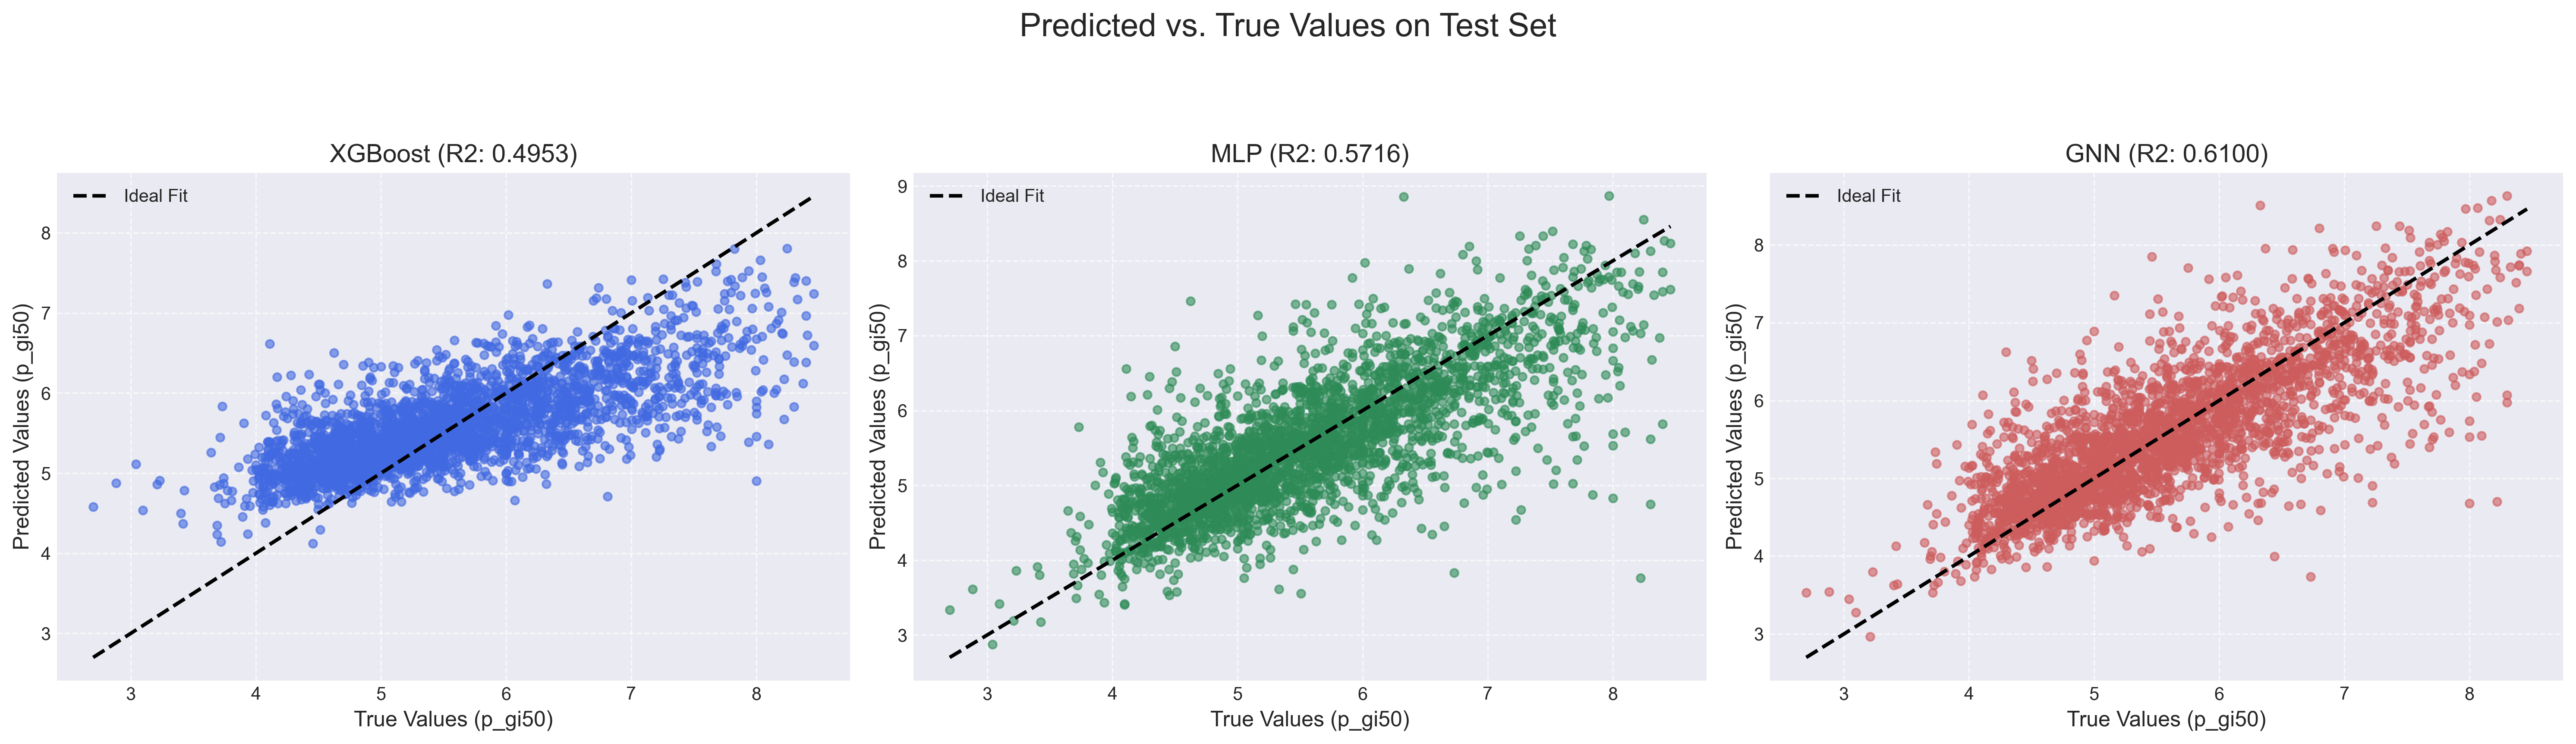


--- Model Performance Visualizations Complete ---


In [64]:
print("\n--- Generating Model Performance Visualizations ---")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 300 # High resolution for better clarity
plt.rcParams['savefig.dpi'] = 300 # High resolution for saving

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 1 row, 3 columns for 3 models
fig.suptitle('Predicted vs. True Values on Test Set', fontsize=18)

# XGBoost Plot
if xgboost_predictions is not None:
    ax = axes[0]
    ax.scatter(y_test, xgboost_predictions, alpha=0.6, s=20, color='royalblue')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'XGBoost (R2: {model_metrics["XGBoost"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].set_title('XGBoost (Not Available)')
    axes[0].axis('off')


# MLP Plot
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    ax = axes[1]
    ax.scatter(mlp_true_targets, mlp_predictions, alpha=0.6, s=20, color='seagreen')
    ax.plot([mlp_true_targets.min(), mlp_true_targets.max()], [mlp_true_targets.min(), mlp_true_targets.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'MLP (R2: {model_metrics["MLP"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12) # Share y-label with first plot
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].set_title('MLP (Not Available)')
    axes[1].axis('off')


# GNN Plot
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    ax = axes[2]
    ax.scatter(gnn_true_targets, gnn_predictions, alpha=0.6, s=20, color='indianred')
    ax.plot([gnn_true_targets.min(), gnn_true_targets.max()], [gnn_true_targets.min(), gnn_true_targets.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'GNN (R2: {model_metrics["GNN"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12) # Share y-label with first plot
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[2].set_title('GNN (Not Available)')
    axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
plt.show()

print("\n--- Model Performance Visualizations Complete ---")

## Plot Residuals vs Predictions
Residual = True Value - Predicted Value


--- Analyzing Model Residuals ---


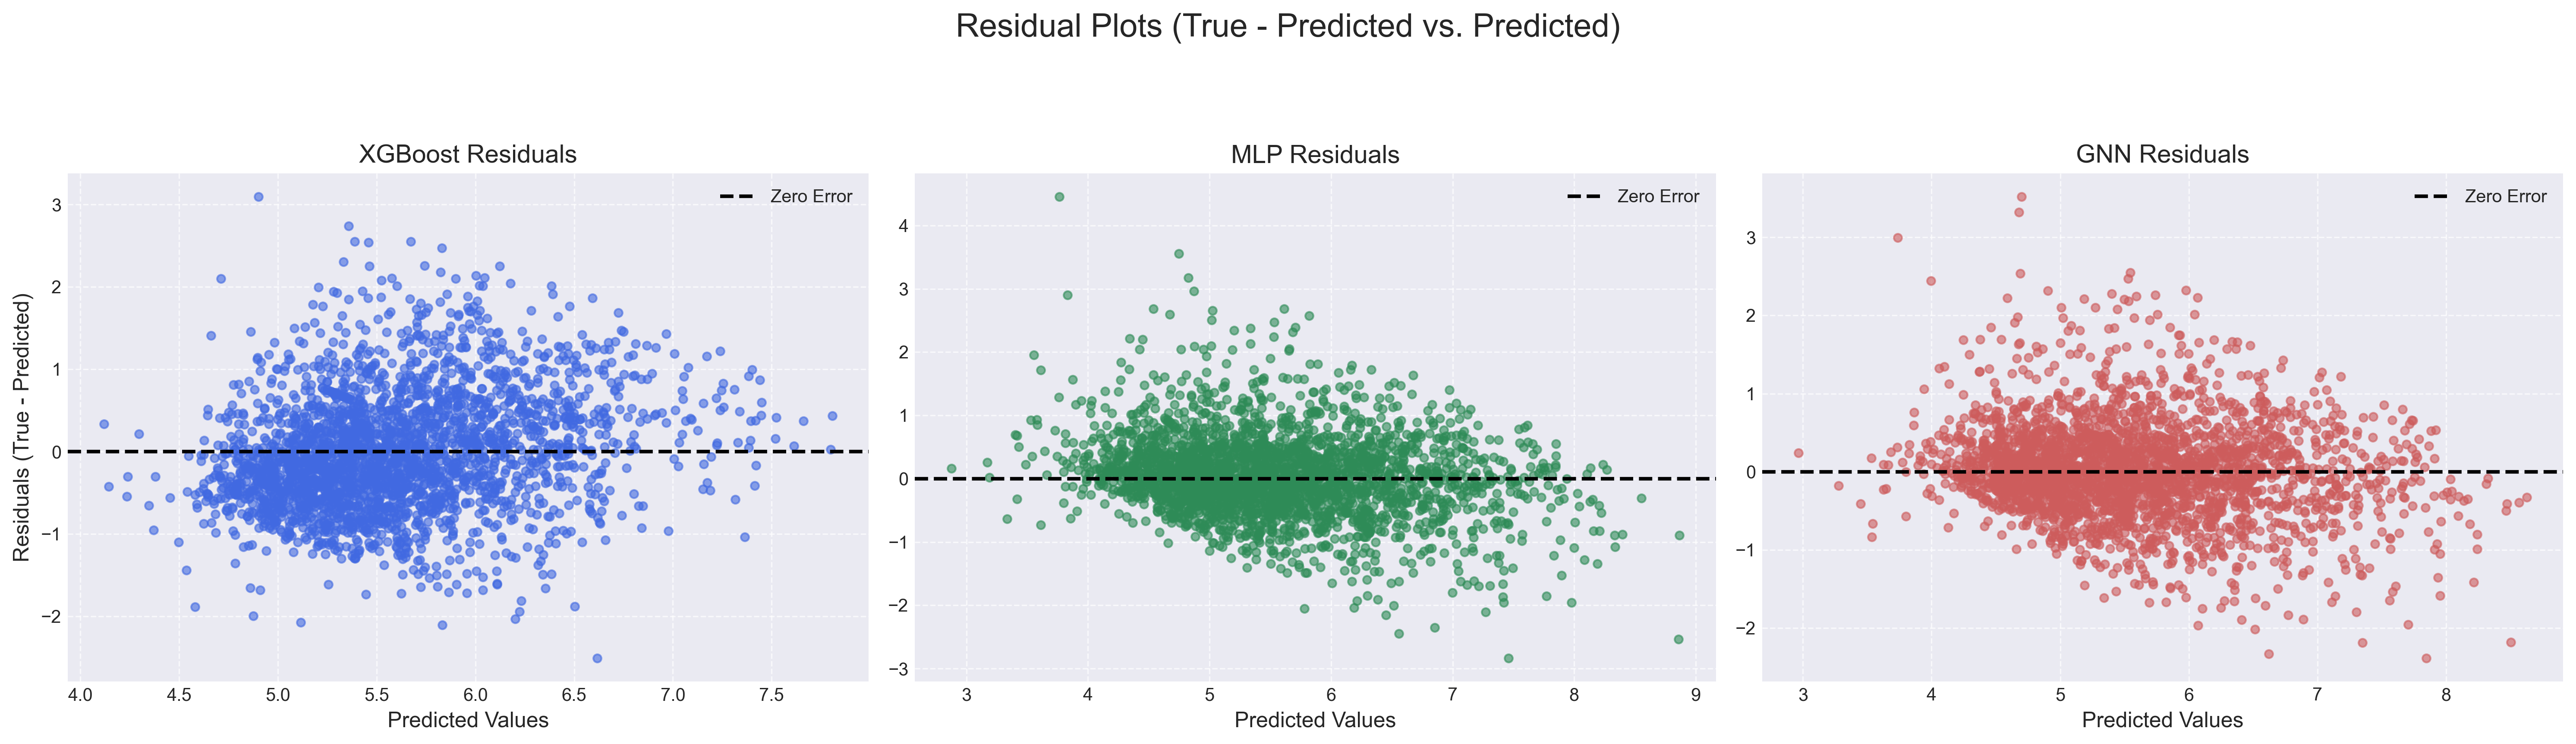


--- Residual Analysis Visualizations Complete ---


In [66]:
print("\n--- Analyzing Model Residuals ---")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Residual Plots (True - Predicted vs. Predicted)', fontsize=18)

# XGBoost Residual Plot
if xgboost_predictions is not None:
    ax = axes[0]
    # Ensure both y_test and xgboost_predictions are NumPy arrays for direct subtraction
    residuals_xgb = y_test.values.flatten() - xgboost_predictions.flatten()

    ax.scatter(xgboost_predictions.flatten(), residuals_xgb, alpha=0.6, s=20, color='royalblue')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('XGBoost Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.set_ylabel('Residuals (True - Predicted)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].set_title('XGBoost Residuals (Not Available)')
    axes[0].axis('off')


# MLP Residual Plot
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    ax = axes[1]
    residuals_mlp = np.array(mlp_true_targets).flatten() - np.array(mlp_predictions).flatten()
    ax.scatter(np.array(mlp_predictions).flatten(), residuals_mlp, alpha=0.6, s=20, color='seagreen')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('MLP Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].set_title('MLP Residuals (Not Available)')
    axes[1].axis('off')


# GNN Residual Plot
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    ax = axes[2]
    residuals_gnn = np.array(gnn_true_targets).flatten() - np.array(gnn_predictions).flatten()
    ax.scatter(np.array(gnn_predictions).flatten(), residuals_gnn, alpha=0.6, s=20, color='indianred')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('GNN Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[2].set_title('GNN Residuals (Not Available)')
    axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

print("\n--- Residual Analysis Visualizations Complete ---")